# IMDB Reviews Classification

This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review.

[Notebook](https://www.kaggle.com/code/muhdsaeid/text-classicfication)

[Data](https://www.kaggle.com/datasets/pankrzysiu/keras-imdb-reviews)

In [2]:
# module used
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import losses

2025-12-15 18:11:23.538893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765822283.880063      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765822283.973432      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
# copying the data to /kaggale/Working for directory modification
source_dir = '/kaggle/input/keras-imdb/'
destination_dir = '/kaggle/working/keras-imdb_mutable/'

print(f"Copying data from {source_dir} to {destination_dir}...\n")


try:
    # Use copytree to recursively copy the entire directory structure
    shutil.copytree(source_dir, destination_dir)
    print()
    print("Copy complete. Data is now mutable in the working directory.")
except FileExistsError:
    # Handle the case where you run the cell twice
    print(f"Directory {destination_dir} already exists. Skipping copy.")
except Exception as e:
    # Handle other potential errors
    print(f"An unexpected error occurred during copy: {e}")

Copying data from /kaggle/input/keras-imdb/ to /kaggle/working/keras-imdb_mutable/...


Copy complete. Data is now mutable in the working directory.


## Data Loading and Preprocessing

In [4]:
data_dir="/kaggle/working/keras-imdb_mutable/aclImdb_v1/aclImdb"
os.listdir(data_dir)

['README', 'test', 'train', 'imdbEr.txt', 'imdb.vocab']

In [5]:
train_dir = os.path.join(data_dir,"train")
print(os.listdir(train_dir))
print()
print(len(train_dir))

['unsupBow.feat', 'pos', 'unsup', 'neg', 'labeledBow.feat', 'urls_neg.txt', 'urls_unsup.txt', 'urls_pos.txt']

59


In [6]:
sample_file = os.path.join(train_dir,"neg/10000_4.txt")
with open(sample_file) as f:
    print(f.read())

Airport '77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman Philip Stevens (James Stewart) who is flying them & a bunch of VIP's to his estate in preparation of it being opened to the public as a museum, also on board is Stevens daughter Julie (Kathleen Quinlan) & her son. The luxury jetliner takes off as planned but mid-air the plane is hi-jacked by the co-pilot Chambers (Robert Foxworth) & his two accomplice's Banker (Monte Markham) & Wilson (Michael Pataki) who knock the passengers & crew out with sleeping gas, they plan to steal the valuable cargo & land on a disused plane strip on an isolated island but while making his descent Chambers almost hits an oil rig in the Ocean & loses control of the plane sending it crashing into the sea where it sinks to the bottom right bang in the middle of the Bermuda Triangle. With air in short supply, water leaking in & having flown over 200 miles off course the problems mount for t

In [7]:
# To prepare a dataset for binary classification,
# you will need two folders on disk, corresponding to neg and pos class
# hence removing the other third folder 'unsup' in the directory
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [8]:
# assigns classes alphabetically.i.e, neg takes class 0 and pos takes class 1
# each folder is class of its own
train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=32,
    seed=2025,
    validation_split=0.2,
    subset="training"
    
)

test_dir = os.path.join(data_dir,'test')

val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=32,
    subset='validation',
    seed=2025,
    validation_split=0.2
    
)

test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=32,
    shuffle=False
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2025-12-15 18:20:51.599382: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [9]:
for text_batch,label_batch in train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'Before this made for TV movie began, I had relatively low expectations. That\'s because it was made after the final episode of the series had aired and many of the series originals were gone. There is no President Sheridan, Delenn, Lennier, Londo, Vir, G\'kar or Lyta. If you remember, on the second to last episode of the series, all the regulars except Zack, Vir and Captain Lockley left B-5 permanently. Now for this film they did bring back Garibaldi (who was not in the last B-5 movie) to join Zack and the Captain and the Doctor makes a brief and irrelevant appearance. But because so much is gone of the old chemistry, this film already is severely handicapped.<br /><br />The movie is about a Soul Hunter (Martin Sheen) who is led to Babylon 5 in search of a globe filled with souls that had been stolen from a hidden repository by an archaeologist (Ian McShane). A lot of spooky mumbo-jumbo stuff occurs but frankly it was all pretty silly and pointless. Yeah, yeah, the station nea

In [10]:
# assigns classes alphabetically.i.e, neg takes class 0 and pos takes class 1

print("Label 0 corresponds to", train_ds.class_names[0])
print("Label 1 corresponds to", train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [11]:
# standarize data to lower case, remove html tags
# for text preprocessing
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    strip_html = tf.strings.regex_replace(lowercase,'<br />'," ")
    return tf.strings.regex_replace(strip_html,'[%s]'
                                    % re.escape(string.punctuation),'')

In [12]:
# this layer standardize, tokenize, and vectorize the text data
vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = 10000,
    output_mode = 'int',
    output_sequence_length = 256
)

In [13]:
# the lambda fn, takes text batch and label batch
# and only return text batch for the vectorize_layer to adapt
train_text = train_ds.map(lambda x,y: x)
# fits train_text
vectorize_layer.adapt(train_text)

In [14]:
# this function a dimension to the text batch and apply vectorization
def vectorize_text(text,label):
    text = tf.expand_dims(text,-1)
    return vectorize_layer(text),label

In [15]:
text_batch, label_batch = next(iter(train_ds))
first_review, first_label = text_batch[0], label_batch[0]



In [16]:
first_review

<tf.Tensor: shape=(), dtype=string, numpy=b"Massacre is a film directed by Andrea Bianchi (Burial Ground) and produced by legendary Italian horror director Lucio Fulci. Now with this mix of great talent you would think this movie would have been a true gore fest. This could not be further from that. Massacre falls right on its face as being one of the most boring slasher films I have seen come out of Italian cinema. I was actually struggling to stay awake during the film and I have never had that problem with Italian horror films.<br /><br />Massacre starts out with a hooker being slaughtered on the side of the road with an ax. This scene was used in Fulci's Nightmare Concert. This isn't a bad scene and it raises your expectations of the movie as being an ax wielding slaughter. Unfortuanitly, the next hour of the movie is SO boring. The movie goes on to a set of a horror film being filmed and there is a lot of character development during all these scenes but the characters in the movi

In [17]:
print("Label",train_ds.class_names[first_label])
print("Vectorized review:\n", vectorize_text(first_review, first_label))


Label neg
Vectorized review:
 (<tf.Tensor: shape=(1, 256), dtype=int64, numpy=
array([[3304,    7,    3,   19,  522,   32,    1,    1, 7143, 1570,    4,
        1100,   32, 2645, 1130,  197,  172,    1, 6539,  148,   16,   11,
        1527,    5,   83,  661,   22,   59,  102,   11,   17,   59,   25,
          75,    3,  271,  670, 5343,   11,   97,   21,   27,  999,   36,
          12, 3304,  723,  208,   20,   29,  405,   14,  108,   28,    5,
           2,   87,  348, 1171,   95,   10,   25,  106,  204,   45,    5,
        1130,  435,   10,   13,  155, 2436,    6,  757, 4029,  302,    2,
          19,    4,   10,   25,  109,   64,   12,  433,   16, 1130,  197,
          95, 3304,  502,   45,   16,    3, 7348,  108, 9224,   20,    2,
         511,    5,    2, 1287,   16,   33, 9952,   11,  131,   13,  334,
           8,    1, 1676, 3039,   11,  209,    3,   81,  131,    4,    9,
        4944,  122, 1362,    5,    2,   17,   14,  108,   33, 9952, 8967,
        4531,    1,    2,  361,  

In [18]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print("   0 ---> ",vectorize_layer.get_vocabulary()[0])
print("   1 ---> ",vectorize_layer.get_vocabulary()[1])
print("   2 ---> ",vectorize_layer.get_vocabulary()[2])




print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  road
 313 --->  excellent
   0 --->  
   1 --->  [UNK]
   2 --->  the
Vocabulary size: 10000


In [19]:
# apply the preprocessing to the data
train_set = train_ds.map(vectorize_text)
val_set = val_ds.map(vectorize_text)
test_set = test_ds.map(vectorize_text)

In [20]:
# Performance Optimization

# Use AUTOTUNE to let TensorFlow determine optimal buffer sizes based on system resources.
AUTOTUNE = tf.data.AUTOTUNE

# .cache(): Caches the dataset in memory or on local disk after the first epoch. 
# This skips re-running the costly I/O and vectorization steps in subsequent epochs.
# .prefetch(): Overlaps data preprocessing (CPU) with model training (GPU/TPU).
# While the model trains on the current batch, the next batch is being loaded and prepared.
train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

# The datasets are now fully prepared, vectorized, and optimized for model training.

In [21]:
# txt cxn model
max_features = 10000
embedding_dim = 16

model = tf.keras.models.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1,activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',  # Watch the validation loss
        patience=3,          # Wait 3 epochs for improvement before stopping
        mode='min',          # Stop when the validation loss stops decreasing
        verbose=1,           # Log when the training stops
        restore_best_weights=True
    )
model.compile(optimizer='adam',
             loss=losses.BinaryCrossentropy(from_logits=False),
             metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [23]:
history=model.fit(train_set,
                  validation_data=val_set,
                  epochs=50,
                  callbacks=early_stopping)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - binary_accuracy: 0.6015 - loss: 0.6816 - val_binary_accuracy: 0.7318 - val_loss: 0.6138
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.7568 - loss: 0.5756 - val_binary_accuracy: 0.8080 - val_loss: 0.5023
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8251 - loss: 0.4626 - val_binary_accuracy: 0.8268 - val_loss: 0.4324
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8540 - loss: 0.3926 - val_binary_accuracy: 0.8464 - val_loss: 0.3879
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - binary_accuracy: 0.8703 - loss: 0.3476 - val_binary_accuracy: 0.8566 - val_loss: 0.3584
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8805 - loss: 0.3144 - val_binary_accuracy: 0.8618 - val_loss: 0.3396
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8923 - loss: 0.2892 - val_binary_accuracy: 0.8680 - val_loss: 0.3258
Epoch 

In [24]:
loss,accuracy = model.evaluate(test_set)
print(f"Evaluation Loss:{loss:.2f}")
print(f"(Evaluation Accuracy:{accuracy:.2f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accuracy: 0.8828 - loss: 0.2906
Evaluation Loss:0.31
(Evaluation Accuracy:0.87


In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

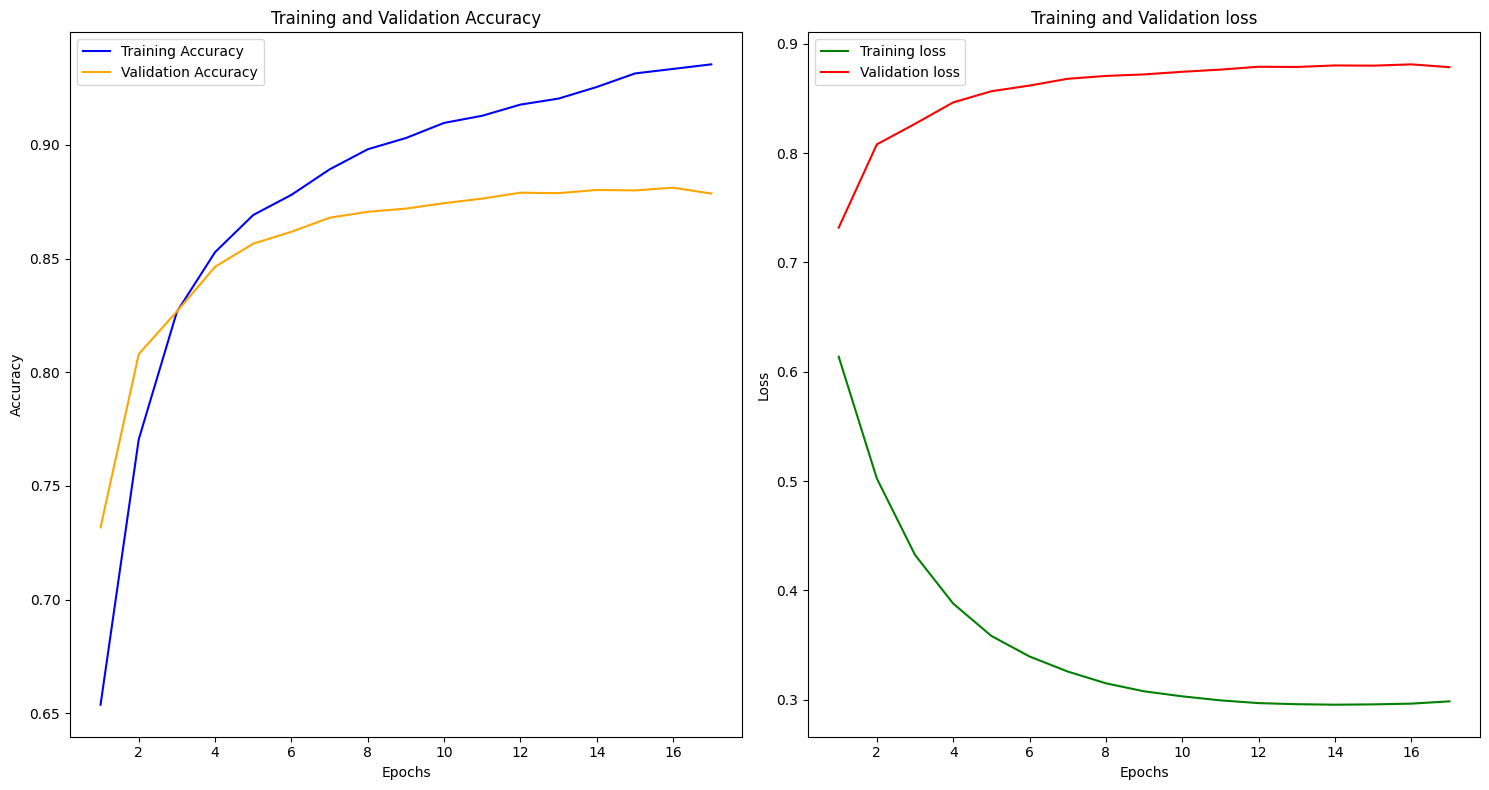

In [26]:
acc = history_dict['binary_accuracy']
val_acc = history_dict["val_binary_accuracy"]
loss = history_dict["val_loss"]
val_loss = history_dict["val_binary_accuracy"]

epochs = range(1,len(acc)+1)
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(epochs,acc,label="Training Accuracy",color='blue')
plt.plot(epochs,val_acc,label="Validation Accuracy", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs,loss,label="Training loss",color='green')
plt.plot(epochs,val_loss,label="Validation loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation loss")
plt.legend()


plt.tight_layout()

In [27]:
# final model for inference
text_cxn_model = tf.keras.Sequential([
    vectorize_layer,
    model
])

text_cxn_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='Adam',
    metrics=['Accuracy']
)

metrics = text_cxn_model.evaluate(test_ds, return_dict=True)
print(metrics)

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - Accuracy: 0.8828 - loss: 0.2906
{'Accuracy': 0.8734800219535828, 'loss': 0.3113076984882355}


## Inference on New Data

In [28]:
examples = tf.constant([
    "'Attack on Titans' is on one of the best anime I have seen",
    "Bleach was good fighting scence overall was average",
    "Naruto was the best anime I have seen"
    "The movie was great!",
    "The movie was okay.",
    "The movie was terrible..."
])

In [29]:
preds = text_cxn_model.predict(examples)
binary_preds = tf.where(preds > 0.5,1,0)

class_names = train_ds.class_names
binary_class_preds = tf.gather(class_names, binary_preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


In [30]:
print(binary_class_preds)

tf.Tensor(
[[b'pos']
 [b'pos']
 [b'pos']
 [b'neg']
 [b'neg']], shape=(5, 1), dtype=string)
